In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/train_submission.csv')
df

,Usage,Text,Label
0,Public,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau
1,Public,Filmen forteller historien om Will Hunting en...,nob
2,Public,An Arthrostylidium berryi in uska species han ...,wln
3,Public,Kancunarí enemigosniyquichejta munacuychej al...,quh
4,Public,Warmeqa ama yachachichunchu hermanospa tantaku...,quh
...,...,...,...
190594,Public,Publié par Masken à 22:46 Aucun commentaire:,hat
190595,Public,ειπεν δε προς τους μαθητας ελευσονται ημεραι ο...,grc
190596,Public,Ya bay boch ban’en ni kug rung’aged ni ga be y...,yap
190597,Public,P'alimentase nun absuerben el sangre sinón qu...,ast


In [3]:
df['Label'].value_counts()

Label
tgk    1500
hbs    1000
mon    1000
crh    1000
som    1000
       ... 
crs       2
kua       1
toi       1
gcr       1
gaa       1
Name: count, Length: 389, dtype: int64

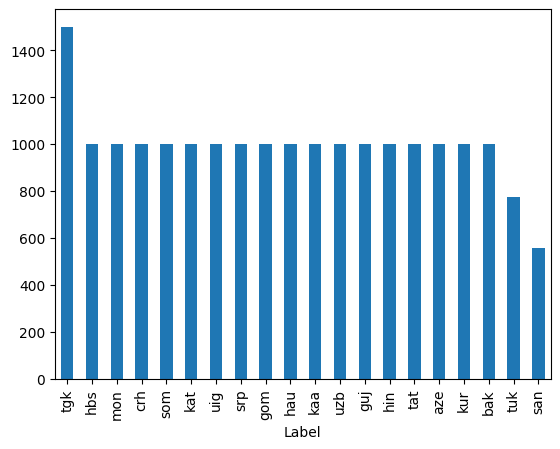

In [4]:
# see data distribution
import matplotlib.pyplot as plt
import seaborn as sns


#only the top 20 classes

df['Label'].value_counts().head(20).plot(kind='bar')
plt.show()

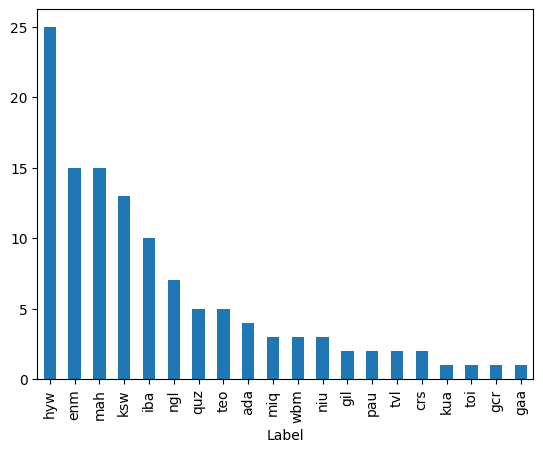

In [5]:
#only the buttom 20 classes

df['Label'].value_counts().tail(20).plot(kind='bar')
plt.show()

In [6]:
df

,Usage,Text,Label
0,Public,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau
1,Public,Filmen forteller historien om Will Hunting en...,nob
2,Public,An Arthrostylidium berryi in uska species han ...,wln
3,Public,Kancunarí enemigosniyquichejta munacuychej al...,quh
4,Public,Warmeqa ama yachachichunchu hermanospa tantaku...,quh
...,...,...,...
190594,Public,Publié par Masken à 22:46 Aucun commentaire:,hat
190595,Public,ειπεν δε προς τους μαθητας ελευσονται ημεραι ο...,grc
190596,Public,Ya bay boch ban’en ni kug rung’aged ni ga be y...,yap
190597,Public,P'alimentase nun absuerben el sangre sinón qu...,ast


In [7]:
test = pd.read_csv('data/test_without_labels.csv')

In [8]:
test

,Usage,Text
0,Private,Hüttwilen el xe on comune del Canton Turgovia ...
1,Private,La leĝo zorgas pri kompenso de nur la plej gra...
2,Private,پک اپ پر اپنے ڈرائیور سے پہلے پہنچیں
3,Private,Mukmu Ch'itana mukmu icha Butun nisqaqa nisqa...
4,Private,Iwe lon ena fansoun lupwen ra aleani än Mo...
...,...,...
190562,Private,Seksyon fin travèse à portant paske tout aran...
190563,Private,ἐξῆλθεν δὲ εἰς ⸀Ταρσὸν ἀναζητῆσαι Σαῦλον
190564,Private,Mi yigo’o sugnagrad e Kan Nthothup miyad tabab...
190565,Private,En dellos ensayos yá teo camentao esos momento...


In [9]:
# drop usage column
df = df.drop(columns=['Usage'])
test = test.drop(columns=['Usage'])

In [10]:
# remove duplicates
df = df.drop_duplicates()

No duplicate rows,  but see:

In [11]:
# see the lines 178069, 141957 and 64261 in the df
df.loc[[178069, 141957, 64261]]

,Text,Label
178069,Da Ort hod bei da Voikszejung 94,mwl
141957,Da Ort hod bei da Voikszejung 94,nso
64261,Da Ort hod bei da Voikszejung 94,hin


we can see that there are many duplicate Texts in the training data that have different labels, since we don't know which one of the labels is the correct one, we will try deleting all different rows that have texts that are duplicate

In [12]:
# delete all rows that have Texts that are duplicated
df = df.drop_duplicates(subset='Text')

In [13]:
df

,Text,Label
0,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau
1,Filmen forteller historien om Will Hunting en...,nob
2,An Arthrostylidium berryi in uska species han ...,wln
3,Kancunarí enemigosniyquichejta munacuychej al...,quh
4,Warmeqa ama yachachichunchu hermanospa tantaku...,quh
...,...,...
190594,Publié par Masken à 22:46 Aucun commentaire:,hat
190595,ειπεν δε προς τους μαθητας ελευσονται ημεραι ο...,grc
190596,Ya bay boch ban’en ni kug rung’aged ni ga be y...,yap
190597,P'alimentase nun absuerben el sangre sinón qu...,ast


le nombre de lignes donc est a diminué de 190600  à 190561   

In [14]:
# rows with nan values in the label column
df[df['Label'].isna()]

,Text,Label
107,Kòe bô jōa kú hō͘-sū sió-chiá lâi kā góan mn̄...,NaN
803,Söğütçük sī chi̍t ê tī Türkiye Aydın séng Çine...,NaN
1095,Golden Valley Kūn ū khó-lêng sī kóng:,NaN
1894,Tī Montégut-Lauragais ê sì-ûi ū Nogaret Revel...,NaN
2499,Soveria Simeri ùi séng lāi ê hoān-ûi.,NaN
...,...,...
189637,Bellebrune sī ūi-tī Hoat-kok Nord-Pas-de-Calai...,NaN
189946,Bô phah-sǹg tī sin-le̍k 10 go̍eh 29 hō ē-po͘ ...,NaN
189959,Wiejki sī chi̍t ê tī Pho-lân Kiōng-hô-kok Podl...,NaN
190397,Tī pún só͘-chāi sì-ûi ê tē-hng ū Valy Veselí ...,NaN


Possiblement, ces texts sont écrites en "Min Nan Chinese" language, qui a pour code le code "nan".

C'est pour cette raison que le label de ces texts est transformé en NaN (valeur nulle)

Une approche pour résoudre ce probleme est de convertir ces labels en string 'nan'. Par contre puisque l'évaluation finale du modèle se fait via la plateforme Kaggle, et j'estime que la méthode utilisé pour lire le fichier csv d'évaluation ne permet pas de lire les 'nan' en tant que string, c'est mieux de ne plus considérer cette classe 'nan' dans l'entrainnement

In [15]:
# drop rows that have Nan values in label
df = df.dropna(subset=['Label'])

Pour avoir une accuracy maximale

In [16]:
#see how many classes have more than 15 samples
df['Label'].value_counts()[df['Label'].value_counts()>15].shape

(370,)

In [17]:
# drop categories that have less than 15 samples
df = df.groupby('Label').filter(lambda x: len(x) > 15)

In [18]:
print(df.isnull().sum())

Text     0
Label    0
dtype: int64


In [18]:
# save the new df

df.to_csv('data/train_submission_preprocessed.csv', index=False)

In [27]:
test.to_csv('data/test_without_labels_preprocessed.csv', index=False)

# Anomalies...

In [20]:
# see all 'hat' texts

hat_df =df[df['Label'] == 'hat']
print(hat_df.iloc[2]['Text'])
print(hat_df.iloc[-1]['Text'])
hat_df

1927 : Pour l'amour de Mike (For the Love of Mike) de Frank Capra : Mary
Publié par Masken à 22:46 Aucun commentaire:


,Text,Label
16,PIVX Swazi Lilangeni (SZL) 58.36709 L PIVX → SZL,hat
384,Harleigh PA Harlem PA Harleysville PA Harmo...,hat
633,1927 : Pour l'amour de Mike (For the Love of M...,hat
822,mwen kwè mwen pale de sa deja lan yon lòt pòs ...,hat
828,MP G16 SLIM PISTOL GRIP - DARK...,hat
...,...,...
188508,nme ak Fazrul...tp sume mmber ak pnggil ak Jer...,hat
189243,Ansyen minis transpò Soluk te vizite TÜDEMSAŞ,hat
190506,Ki jan ou fè jwenn DA a Pentax 55-300 konpare ...,hat
190543,Plan jigo dwat Vole postal devan ak fèmti bout...,hat


avec le label 'hat' et meme avec bcp d'autres label, on a trouvé que la labéllisation n'est pas correcte. plein de texts qu'on est sûr de leurs langagues sont mal labéllisé. Mais nous allons continuer à tarvailler sur même dataset (bien qu'elle est contient bcp d valeurs incorrectes) car nous voulons maximiser le score d'accuracy du test, et après plusieurs investigations et analyses, nous avons compris que le data du test suit la meme distribution et contient des valeurs incorrectes aussi.

# Extract the true labels of some of the test rows

déjà, y a des texts du test qu'on sait dèjà leurs labels à partir du train (meme texts dans train et test data) xD

In [21]:
# check if any Text of test dataframe column existts in df dataframe column
texts_in_df = test[test['Text'].isin(df['Text'])]
texts_in_df

,Text
651,Ukusebenza kwenzuzo yokutjala kwatjhejwa qobe ...
3077,Selain itu para anggota dewan juga berjanji a...
7761,Edward Ago-Ackam yɛ kane Ghanani amanyɔni. ɔyɛ...
8807,Boleh dengan menggunakan pemanasan secara lang...
16092,Esikunqophileko kukwandisa amazinga wokuzitlol...
19345,Amabuthelelo wekhompyutha azakugcinwa ngerhubh...
33574,Wɔwoo no ogyefuo bosome a ɛtɔ so num afe aha n...
36987,Wɔwoo no 1980 wɔ akukudam abusua mu wɔ Asante...
38704,"a b"". * In this case the first string is ""a""..."
39059,I- NHBRC yihlangano yombuso ehlonywe ngokomThe...


In [22]:
# assign the labels of each element in texts_in_df to the corresponding element in df while conserving the order of the elements in texts_in_df and their IDs

for index, row in texts_in_df.iterrows():
    texts_in_df.loc[index, 'Label'] = df.loc[df['Text'] == row['Text'], 'Label'].values[0]
texts_in_df


/tmp/ipykernel_2857075/2611585015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_in_df.loc[index, 'Label'] = df.loc[df['Text'] == row['Text'], 'Label'].values[0]


,Text,Label
651,Ukusebenza kwenzuzo yokutjala kwatjhejwa qobe ...,nbl
3077,Selain itu para anggota dewan juga berjanji a...,ban
7761,Edward Ago-Ackam yɛ kane Ghanani amanyɔni. ɔyɛ...,aka
8807,Boleh dengan menggunakan pemanasan secara lang...,mad
16092,Esikunqophileko kukwandisa amazinga wokuzitlol...,nde
19345,Amabuthelelo wekhompyutha azakugcinwa ngerhubh...,nde
33574,Wɔwoo no ogyefuo bosome a ɛtɔ so num afe aha n...,twi
36987,Wɔwoo no 1980 wɔ akukudam abusua mu wɔ Asante...,twi
38704,"a b"". * In this case the first string is ""a""...",uig
39059,I- NHBRC yihlangano yombuso ehlonywe ngokomThe...,nbl


peut etre, on peut utiliser apres cette info :)

In [ ]:
# save the dataframe to a csv file 

texts_in_df.to_csv('tests.csv', index=True)

# testing

essayons si Kaggle accepte le string 'nan' que nous avons dans le train 

In [19]:
# create a new dataframe that has the same line numbers as test and that has 2 columns: ID and Label, the id from 1 to nombre_de_lignes+1 and the labels are all 'tgk'
import csv

df3 = pd.DataFrame(list(zip(range(1,190568), ["nan"]*190568)), columns=['ID', 'Label'])
df3.to_csv('submission.csv', index=False)
df3


,ID,Label
0,1,nan
1,2,nan
2,3,nan
3,4,nan
4,5,nan
...,...,...
190562,190563,nan
190563,190564,nan
190564,190565,nan
190565,190566,nan


In [20]:
dff= pd.read_csv('submission.csv')
dff

,ID,Label
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN
...,...,...
190562,190563,NaN
190563,190564,NaN
190564,190565,NaN
190565,190566,NaN


In [9]:
# Définir le nombre de lignes
n = 190567

# Créer le DataFrame avec 2 colonnes : 'ID' et 'Label'
df3 = pd.DataFrame({
    'ID': range(1, n+1),
    'Label': ['nan'] * n
})

# S'assurer que la colonne 'Label' est de type string
df3['Label'] = df3['Label'].astype(str)

# Remplacer toute valeur manquante par "nan" (au cas où)
df3 = df3.fillna("nan")

# Exporter en CSV avec toutes les valeurs entre guillemets, et écrire "nan" si jamais une valeur manquante existe
df3.to_csv('submission.csv', index=False, quoting=csv.QUOTE_ALL, na_rep="nan")
df3.head()

,ID,Label
0,1,nan
1,2,nan
2,3,nan
3,4,nan
4,5,nan


In [12]:
import io
import tempfile
from kaggle import api  # Assurez-vous d'avoir installé la bibliothèque kaggle

# Supposons que df est votre DataFrame de soumission
# Convertir le DataFrame en CSV dans un buffer en mémoire
csv_buffer = io.StringIO()
df3.to_csv(csv_buffer, index=False)

# Créer un fichier temporaire et y écrire le contenu CSV
with tempfile.NamedTemporaryFile(mode="w+", suffix=".csv", delete=False) as tmp:
    tmp.write(csv_buffer.getvalue())
    tmp_path = tmp.name  # Chemin du fichier temporaire

# Soumettre le fichier en utilisant l'API Kaggle
# Remplacez 'competition-name' par le nom exact de la compétition sur Kaggle
api.competition_submit(file_name=tmp_path, message="Submission from Notebook", competition="nlp-cs-2025")


100%|██████████| 1.89M/1.89M [00:01<00:00, 1.70MB/s]


Successfully submitted to NLP CS 2025

ca marche pas :( donc continuons à travailler avec la data du train sans devoir considérer le label 'nan' du langague "Min Nan Chinese"

Finalement, on a produit un nouveau fichier du test pour lequel on a droper les valeurs nulles, on a supprimer les texts dupliqués ayant à chaque fois un label différent, et on n'a considérer que les labels ayant plus de 15 elemnents [ça nous pénalise de 0.000205 dans l'accuracy du test :(]